# Can you hear the size of a reservoir?

MOD510: Mandatory project #2

Deadline: 17 October 2021 (23:59)

## Abstract ##


In this Project different methods for modeling a reservoir and simulating the pressure distribution inside it are explored, in order to estimate the size of a reservoir, using messured well pressure data. 

At first a model simulating a steady state of the pressure distirbution is created with two different boundary conditions at the outer rim of the reservoir ("Lazy" and "Advanced"). While the error of the "Lazy" boundary condition scales proportional with the cell-size (Higher N => smaller dy => smaller error), the "Advanced" boundary condition does not introduce such error. Because the truncation error is zero for both cases the "Advanced" boundary condition error is basically zero and independent from N.

Afterwards a timdependent simulation to explore the evolution of the pressuredistribution over time - and especially the evolution of the well pressure, which can be physically measured - is created. Two different well models (considering the well as a zylinder or as a line) and three different matrix solvers (Dense matrix solver, Thomas Algorithm and SciPy matrix solver) are compared. The "Line-source" solution is inacurate close to the well and for low N. For low N the fastest solver is the Dense matrix solver and for high N the SciPy matrix solver.

Lastly the well pressure from the model is compared with messured data from a real reservoir and the parameters of the model are tuned to match it to the data. From this a reservoir radius of about 7600ft and a total water volume of about 8202000 cubic meters can be derived.

## Introduction ##


Reservoir characterization, especially estimating the storage capacity of the reservoir, is an important issue to ensure the economic profitability for oil and gas projects. However nowadays, due to greenhouse effects that ultimately lead to Global Warming, the world has become more concerned about carbon management. Carbon capture & storage is considered as one solution to reduce the carbon buildup in the atmosphere. Storage capacity in reservoirs plays a vital role as they are potential zones for this solution. However, the estimation of the storage capacity of depleted oil and gas reservoirs depends on many ambiguities such as rock formation, injection strategies, trapping mechanism, pressure build up and decline characteristics etc. [1]. There are many ways to estimate the storage capacity of a reservoir. In the following using messured well pressure data to match a computational reservoir model to the real reservoir is explored as one of these ways.

### Problem definition ###


In the models created a reservoir is considered to be of a cylindrical shape with height $h$, and radius $r_e$. It is containing the (cylindrical) well with radius $r_w$ and constant flow rate $Q$, a porous medium (rock/soil) with a porosity $\phi$ and absolute permeability $k$, and the fluid with viscousity $\mu$. It considers the total (rock+fluid) compressibility $ct$ and initial reservoir pressure $p_i$. A coordinate transformation $y = ln(\dfrac {r}{r_w})$ is used to divide the reservoir into shells that exponentially increase in size the further away from the reservoir they are. Because of the rotational symetry of the model and homogeneous radius over the hight of the reservoir (cylinder) theses shells can be solved as a 1 dimensional grid.

### Physical background ###


Fundamental mechanics of well stimulation can be described by Darcy’s law, where pressure gradient is introduced by flow rates in Reservoir Engineering [2]. From simple computation to multidimensional models, it is proven that fluid flow behavior effects the reservoir pressure in porous media [3]. Injection or Production of fluids creates excessive pressure build up, whereas Reservoir Compaction increases the effective stress [4] and both of these might be the cause of damages in the structure. Well pressure testing is one of the ways to identify these types of problems [5]. This well pressure monitoring during production is an important matter for determining the oil & gas reserve, Carbon Storage capacity, geothermal applications, groundwater monitoring etc. [6]. Decline curve analysis is one of the best methods to approximate the reserve estimation when parameters are unknown [7]. In complex situations, Pseudo-pressure regularization rate is applied under superposition time function to estimate the dynamic reserve [8].

### Import packages ###

In [1]:
import scipy.sparse.linalg
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import scipy.sparse.linalg
import scipy.special as sp
import pandas as pd
import scipy.optimize as sciopt


### Class definition ###

We use the tri_diag function from the Heat Problem as a base for matrix creations:

In [2]:
def tri_diag(a,b,c,k1=-1,k2=0,k3=1):
    '''
    a,b,c diagonal terms
    default k-values for 4x4 matrix:
    | b0 c0 0  0  |
    | a0 b1 c1 0  |
    | 0  a1 b2 c2 |
    | 0  0  a2 b3 |
    '''
    return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)

To solve the problems we use a class based on the RadialDiffusivityEquationSolver blueprint provided in appendix D of the project description:

In [3]:
class RadialDiffusivityEquationSolver:
    """
    A finite difference solver for the radial diffusivity equation.
    We use the coordinate transformation y = ln(r/rw) to set up and
    solve the pressure equation.

    The solver uses SI units internally, while "practical field units"
    are required as input.

    Except for the number of grid points and the choice of time step,
    all class instance attributes are provided with default values.

    Input arguments:

        name                                symbol      unit
        --------------------------------------------------------------
        Number of grid points                N          dimensionless
        Constant time step                   dt         days
        Well radius                          rw         ft
        Outer reservoir boundary             re         ft
        Height of reservoir                  h          ft
        Absolute permeability                k          mD
        Porosity                             phi        dimensionless
        Fluid viscosity                      mu         mPas (cP)
        Total (rock+fluid) compressibility   ct         1 / psi
        Constant flow rate at well           Q          bbl / day
        Initial reservoir pressure           pi         psi
        -------------------------------------------------------------
    """

    def __init__(self,
                 N,
                 dt,
                 rw=0.328,
                 re=1000.0,
                 h=8.0,
                 phi=0.2,
                 mu=1.0,
                 ct=7.8e-6,
                 Q=1000.0,
                 k=500,
                 pi=3900.0):

        # Unit conversion factors (input units --> SI)
        self.ft_to_m_ = 0.3048
        self.psi_to_pa_ = 6894.75729
        self.day_to_sec_ = 24.*60.*60.
        self.bbl_to_m3_ = 0.1589873

        # Grid
        self.N_ = N
        self.rw_ = rw*self.ft_to_m_
        self.re_ = re*self.ft_to_m_
        self.h_ = h*self.ft_to_m_

        # Rock and fluid properties
        self.k_ = k*1e-15 / 1.01325
        self.phi_ = phi
        self.mu_ = mu*1e-3
        self.ct_ = ct / self.psi_to_pa_

        # Initial and boundary conditions
        self.Q_ = Q*self.bbl_to_m3_ / self.day_to_sec_
        self.pi_ = pi*self.psi_to_pa_

        # Time control for simulation
        self.dt_ = dt*self.day_to_sec_

        # TO DO: Add more stuff below here....
        # (grid coordinates, dy, eta, etc.)
        self.ye_ = np.log(self.re_/self.rw_)
        self.dy_ = self.ye_/self.N_
        self.y_= np.arange(0,self.ye_,self.dy_)+(self.dy_)/2
        self.r_ = self.rw_*np.exp(self.y_)

        #Set simulation parameters
        #sigma and beta
        self.sigma_ = np.ones(self.N_)
        self.a_ = np.ones(self.N_-1)
        self.b_ = np.ones(self.N_)
        self.c_ = np.ones(self.N_-1)
        self.eta_ = self.k_/(self.mu_*self.phi_*self.ct_)
        self.beta_ = (self.Q_ * self.mu_ * self.dy_)/ (2*np.pi*self.k_*self.h_)
        self.alpha_ = (self.Q_*self.mu_)/(2*np.pi*self.h_*self.k_)
        for i in range(0,self.N_):
            self.sigma_[i]= (self.eta_*np.exp(-2*self.y_[i])*self.dt_)/(np.power(self.rw_,2) * np.power(self.dy_,2))
        for i in range(0,(self.N_-1)):
            self.a_[i]=-self.sigma_[i+1]
            self.c_[i]=-self.sigma_[i]
            self.b_[i]=1+2*self.sigma_[i]
        #Boundary condition-central difference
        self.b_[0]= 1+self.sigma_[0]
        self.b_[-1]=1+3*self.sigma_[-1]
        self.A_=tri_diag(self.a_,self.b_,self.c_)
        #P0
        self.P_old_=np.repeat(self.pi_,self.N_)

            
    #Functions

    def p_analyt(self,y,alpha=1):
        return self.pi_ + (alpha * (y-self.ye_))
    
        
    def steady(self,lazy_boundary=False):    
        alpha=1

        #setup matrix
        a=np.ones(self.N_-1)
        b=-2*np.ones(self.N_)
        c=np.ones(self.N_-1)
        b[0]=-1
        #boundary condition lazy mode and non-lazy mode:
        if lazy_boundary:
            b[-1]=-2
        else:
            b[-1]=-3
        #calculating the matrix
        A=tri_diag(a,b,c)

        #rhs vector
        d=np.zeros(self.N_)

        #rhs boundary condition
        d[0]=alpha*self.dy_

        if lazy_boundary:
            d[-1]=-self.pi_
        else:
            d[-1]=-2*self.pi_
        
        #solve linear differential equation
        self.steady_pn_=np.linalg.solve(A,d)

        #plot result
        self.plot_num_vs_analyt_steady(lazy_boundary)

    def plot_num_vs_analyt_steady(self,lazy_boundary=False):
        
        #set title
        if lazy_boundary:
            plt.title('"Lazy Boundary"')
        else:
            plt.title('"Advanced Boundary"')

        #plot analytical solution
        ya=np.arange(self.dy_/2,self.ye_,0.01)
        pa=self.p_analyt(ya)
        plt.plot(ya,pa,label='analytical')

        #plot numerical solution
        plt.plot(self.y_,self.steady_pn_,'*',label='numerical n = ' + str(self.N_))
        
        plt.xlabel('y-coordinate')
        plt.ylabel('pressure [Pa]')
        plt.grid()
        plt.legend()
        plt.show()
        
    def steady_error(self):
        #error at a single point between numerical and analytical solution
        ni=self.N_//2
        yi=self.y_[ni]
        err=np.abs(self.steady_pn_[ni]-self.p_analyt(yi))
        print('Error at point ',ni,' is ',err)

    def timedependent(self,t_final_days,matrix_solver='dense',plot=False):
        #change final time to second
        self.t_final_ = self.day_to_sec_*t_final_days
        self.t_=[]
        self.t_.append(self.dt_)
        self.pw_=[]
        #matrix for old values of pressure
        self.P_old_ = np.repeat(self.pi_,self.N_)
        #choose between three solvers
        while self.t_[-1]<self.t_final_:
            if matrix_solver == 'dense':
                self.densesolve()
            elif matrix_solver == 'SciPy':
                self.sparse_matrices()
            elif matrix_solver == 'Thomas':
                self.thomas_algorithm()
            self.P_old_=np.copy(self.Pn_)
            if plot:
                self.plot_num_vs_analyt_time()
            self.pw_.append(self.well_pressure())
            self.t_.append(self.t_[-1]+self.dt_)
        self.t_.pop(-1)
    
    def make_rhs(self):
        #right hand side calculation
        self.d_=np.zeros(self.N_)
        self.d_[0]=-self.beta_*self.sigma_[0]
        self.d_[-1]=2*self.pi_*self.sigma_[-1]

    def densesolve(self):
        self.make_rhs()
        self.d_ = self.P_old_+self.d_
        self.dense_Pn_ =np.linalg.solve(self.A_,self.d_)
        self.Pn_ = self.dense_Pn_
    
    def plot_comparisonSolvers(self):
        
        #dense solver plotting
        plt.plot(self.y_,self.dense_Pn_,'*-', label='numerical-dense solver n=' + str(self.N_))
        #scipy solver plotting
        plt.plot(self.y_,self.sparse_Pn_,'*-', label='numerical-scipy solver n=' + str(self.N_))
        #thomas solver plotting
        plt.plot(self.y_,self.Thomas_Pn_,'*-', label='numerical-thomas solver n=' + str(self.N_))
        plt.xlabel('y-coordinate')
        plt.ylabel('Pressure')
        plt.legend()
        plt.grid()

    def plot_num_vs_analyt_time(self):
        #set Title
        plt.title('Pressure distribution at ' + str(self.t_[-1]/(24*60*60))+ ' days')
        
        #plot analytical solution
        ya=np.arange(self.dy_/2,self.ye_,0.01)
        Pa=self.p_analyt(ya,self.alpha_)
        plt.plot(ya,Pa, label='analytical' )
        
        #plot numerical solution
        plt.plot(self.y_,self.Pn_,'*-', label='numerical n=' + str(self.N_))

        plt.legend()
        plt.grid()
        plt.xlabel('y-coordinate')
        plt.ylabel('Pressure [Pa]')
        plt.show()
        
    def line_source(self,t_final):
        self.t_ = self.dt_
        t_final=t_final*self.day_to_sec_
        #solve line source solution in time dependent mode
        while self.t_ < t_final:
            #calculate the x and w
            self.x = -(np.power(self.r_,2))/(4*self.eta_*self.t_)
            self.w = sp.expi(self.x)
            #calculate the pressure
            self.Pr_ = self.pi_ +((self.Q_*self.mu_)/(4*np.pi*self.k_*self.h_))*self.w
            self.t_ += self.dt_
        #return self.Pr_
        
    def plot_num_vs_line(self):
        #set title
        plt.title('Pressure distribution')

        #plot line solution
        plt.plot(self.r_,self.Pr_/6894.75729, label='line-source solution' )
        
        #plot numerical solution
        plt.plot(self.r_,self.Pn_/6894.75729,'*-', label='numerical n =' + str(self.N_))
        
        plt.xlabel('Reservoir Radius [m]')
        plt.ylabel('Pressure [Psi]')
        plt.xscale('log')
        plt.legend()
        plt.grid()

    def sparse_matrices(self):

        self.make_rhs()
        self.d_ = self.P_old_+self.d_
        #generate the matrix values
        diagonals=np.zeros((3,self.N_))
        diagonals[0,0:self.N_-1]= self.a_
        diagonals[0,-1] = 0
        diagonals[1,:]= self.b_
        diagonals[2,0] = 0
        diagonals[2,1:]= self.c_
        diagonals[1,0] = 1+self.sigma_[0]
        diagonals[1,-1] = 1+3*self.sigma_[-1]

        #Set up sparse matrix
        self.A_sparse = sc.sparse.spdiags(diagonals, [-1,0,1], self.N_, self.N_,format='csc')

        # solve matrix
        self.sparse_Pn_ =sc.sparse.linalg.spsolve(self.A_sparse,self.d_)
        self.Pn_ = self.sparse_Pn_

    def thomas_algorithm(self):
        self.make_rhs()
        self.d_= self.P_old_ + self.d_
        r = np.copy(self.d_)
        d = np.copy(np.diag(self.A_, k=0))
        u = np.zeros_like(d)
        l = np.zeros_like(d)
        u[:-1] = np.copy(np.diag(self.A_, k=1))
        l[1:] = np.copy(np.diag(self.A_, k=-1))

        # Allocate memory for solution
        self.Thomas_Pn_ = np.zeros_like(d)
        n = len(self.Thomas_Pn_)

        # # Forward elimination
        for k in range(1, n):
            xmult = l[k] / d[k-1]
            d[k] = d[k] - xmult*u[k-1]
            r[k] = r[k] - xmult*r[k-1]
            
        # Back-substitution
        self.Thomas_Pn_[n-1] = r[n-1] / d[n-1]
        for k in range(n-2, -1, -1):
            self.Thomas_Pn_[k] = (r[k]-u[k]*self.Thomas_Pn_[k+1])/d[k]
        self.Pn_ = self.Thomas_Pn_

    #well pressure calculation
    def well_pressure(self):
        p0=self.Pn_[0]
        pw = p0-(self.Q_*self.mu_*self.dy_)/(4*np.pi*self.h_*self.k_)
        return pw

    def plot_well_pressure(self,timescale='seconds',pressure_unit='pascal',xscale ='linear'):
        plt.title('Wellpressure')
        if timescale == 'seconds':
            t = self.t_
        elif timescale == 'hours':
            t = np.true_divide(self.t_,(60*60)) #converting seconds to hours
        elif timescale == 'days':
            t = np.true_divide(self.t_,(60*60*24)) #converting seconds to days
            
        if pressure_unit =='pascal':
            pw = self.pw
        elif pressure_unit == 'psi':
            pw = np.true_divide(self.pw_,self.psi_to_pa_)

        plt.plot(t,pw,'*',color='m',label='Wellpressure model')
        plt.xlabel(timescale)
        plt.xscale(xscale)
        plt.ylabel(pressure_unit)
        plt.legend()
        plt.grid()

    def pw_interp_fun(self,t_data_hours):
        """
        returns wellpressure at data timepoints in psi
        """
        t_hours = np.true_divide(self.t_,(60*60))
        pw_psi = np.true_divide(self.pw_,self.psi_to_pa_)
        self.pw_interp_psi_ = np.interp(x=t_data_hours,xp=t_hours,fp=pw_psi)

    def calculate_volume(self):
        """
        returns the volume of water/oil in the reservoir in m^3
        """
        return np.pi * self.re_**2 * self.h_ *self.phi_

## Exercise 1: Steady-state solution


### Part 1: Analytical solution ###

To demonstrate the analytical solution, we must first integrate equation(17) from the project description twice. As a result, the first time we integrate, we have:

<br><p style="text-align: center;">$\int \dfrac {d^2p}{dy^2} =\int0$ (1)</p>
<br><p style="text-align: center;">$=>\dfrac{dp}{dy} = C$ (2)</p>
C is an integration constant. By using the well boundary condition $\dfrac{dp}{dy}(y=y_{w})$, which is equal to $\alpha$, C would be $\alpha$.

<br>Integrating both sides of equation (1) results in:
<br><p style="text-align: center;">$\int \dfrac{dp}{dy}=\int\alpha$ (3)</p>
<br><p style="text-align: center;">$=>p(y)= \alpha y + D$ (4)</p>
D is a new integration constant. By using the boundary condition $p(y=y_{e}) = p_{init}$. We investigate that $D = p(y=y_{e}) -\alpha y_{e}$, and therefore $D = p_{init}-\alpha y_{e}$. By inserting this expression into the equation above we get:
<br><p style="text-align: center;">$p(y)=p_{init}+\alpha(y-y_{e})$ (5)</p>

### Part 2: Numerical solution ###

In order to approximate the second derivative of pressure in equation(17) from the project description, we use the central difference formulation, and put $\dfrac{d^2p}{dy^2}$ equal to:
<br><p style="text-align: center;">$p''(y) = \dfrac {p(y+\Delta y) + p(y-\Delta y) - 2p(y)}{\Delta y^2} - \dfrac {1}{2}p^{(4)}(\eta)\Delta y^2$ (6)</p>

<br> As the second derivative of the pressure is equal to zero, the result of equation (6) is also equal to zero. By assuming $P(y) = P_{i}$ , we get:
<br><p style="text-align: center;">$\dfrac {p_{i+1} + p_{i-1} - 2p_{i}}{\Delta y ^2 }- \dfrac {1}{2}p^{(4)}(\eta)\Delta y^2  = 0$ (7)</p>

Writing down (7) for N = 4, we have:
<br><p style="text-align: center;">$(p_{1} + p_{-1} - 2p_{0}) - \dfrac {1}{2} p^{(4)}(\eta)\Delta y^4  = 0$
<br><p style="text-align: center;">$(p_{2} + p_{0} - 2p_{1}) - \dfrac {1}{2} p^{(4)}(\eta)\Delta y^4  = 0$
<br><p style="text-align: center;">$(p_{3} + p_{1} - 2p_{2}) - \dfrac {1}{2} p^{(4)}(\eta)\Delta y^4  = 0$
<br><p style="text-align: center;">$(p_{4} + p_{2} - 2p_{3}) -\dfrac {1}{2}  p^{(4)}(\eta)\Delta y^4  = 0$</p>

<br>The second derivative of pressure is zero, and since the truncation error is based on the fourth drivative of the pressure, this errror term is equal to zero as well. Therefore we have:
<br><p style="text-align: center;">$(p_{1} + p_{-1} - 2p_{0}) = 0$
<br>$(p_{2} + p_{0} - 2p_{1}) = 0$
<br>$(p_{3} + p_{1} - 2p_{2}) = 0$
<br>$(p_{4} + p_{2} - 2p_{3}) = 0$</p>



### Part 3: Lazy boundary condition matrix ###

<br> In order to impose the boundary conditions, as mentioned in the project description, in the lazy option $p_{init}$ is equal to $p_e$, so $p_4$ would be equal to $p_{init}$; however, for the $p_{-1}$ we have no value. As the boundary condition in the well side is $\dfrac {dp}{dy}(y=y_w) = \alpha$ , by using the central difference formulation we have:
<br><p style="text-align: center;">$\left.\frac{dp}{dy}\right|_{y = y_w} = \dfrac {p_1 - p_{-1}}{\Delta y}- \dfrac {2}{3} \Delta y^2 p''' (\eta)$

<br><p style="text-align: center;">$\alpha = \dfrac{p_0 - p_{-1}}{\Delta y} - \dfrac {2}{3} \Delta y^2 p''' (\eta)$

<br><p style="text-align: center;">$=> p_{-1} = p_{0} - \alpha\Delta y-  \dfrac {2}{3} \Delta y^4 p''' (\eta)$</p>

<br>The third derivative of pressure is zero as well so this error would be zero. Then by replacing the value of $p_{-1}$, the first above equation would be:
<br><p style="text-align: center;">$(p_{1} + p_{-1} - 2p_{0}) = 0$
<br>$=>(p_{1} - \alpha\Delta y - p_{0}) = 0$
<br>$=>(-p_{0} + p_{1}) = \alpha\Delta y$</p>
<br> As the value of $p_4$ is assumed to be $p_e$, the above equations would be:
<br><p style="text-align: center;">$-p_{0} + p_{1} = \alpha\Delta y$
<br>$p_{0} - 2p_{1} + p_{2} = 0$
<br>$p_{1} - 2p_{2} + p_{3}   = 0$
<br>$p_{2} - 2p_{3} = -p_e$</p>
<br>The matrix equation we need to solve for N = 4 is:
<br>$$\begin{pmatrix} -1&1&0&0 \\ 1&-2&1&0\\0&1&-2&1\\0&0&1&-2 \end{pmatrix}\begin{pmatrix} p_0 \\ p_1\\p_2\\p_3 \end{pmatrix} =\begin{pmatrix} \alpha \Delta y \\ 0\\0\\-p_e \end{pmatrix} $$


### Part 4: Advanced boundary condition matrix ###

In the not so lazy mode we need to impose another boundary condition at $y=y_e$, and in this case $p_N$, instead of $p_e$; is equal to $2p_e - p_{N-1}$. Therefore the last above equation would be:
<br><p style="text-align: center;">$(p_{4} + p_{2} - 2p_{3}) = 0$
<br>$=>2p_e - p_3 + p_2 - 2p_3 = 0$
<br>$=>p_2- 3p_3 = -2p_e$</p>
<br> and the new matrix is:
<br>$$\begin{pmatrix} -1&1&0&0 \\ 1&-2&1&0\\0&1&-2&1\\0&0&1&-3 \end{pmatrix}\begin{pmatrix} p_0 \\ p_1\\p_2\\p_3 \end{pmatrix} =\begin{pmatrix} \alpha \Delta y \\ 0\\0\\-2p_e \end{pmatrix} $$

### Part 5: Error scaling ###

We implement the lazy boundary condition for $y=y e$ and solve the matrix equation for various N values in the first section. For each value of N we also calculate the error at a single location.

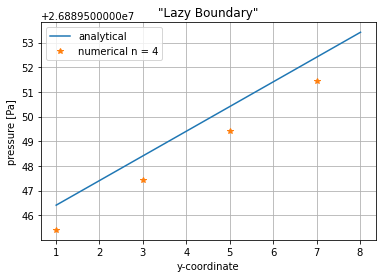

Error at point  2  is  1.0028121210634708


In [4]:

steady_lazy4 = RadialDiffusivityEquationSolver(4,0.01)
steady_lazy4.steady(lazy_boundary=True)
steady_lazy4.steady_error()


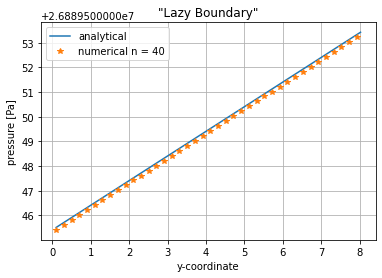

Error at point  20  is  0.1002812348306179


In [5]:

steady_lazy40 = RadialDiffusivityEquationSolver(40,0.01)
steady_lazy40.steady(lazy_boundary=True)
steady_lazy40.steady_error()


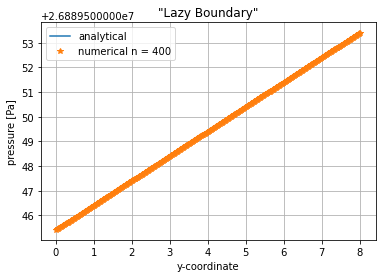

Error at point  200  is  0.010028444230556488


In [6]:

steady_lazy400 = RadialDiffusivityEquationSolver(400,0.01)
steady_lazy400.steady(lazy_boundary=True)
steady_lazy400.steady_error()


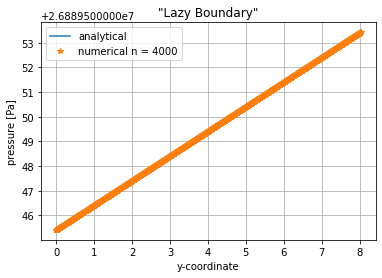

Error at point  2000  is  0.001005370169878006


In [7]:
steady_lazy4000 = RadialDiffusivityEquationSolver(4000,0.01)
steady_lazy4000.steady(lazy_boundary=True)
steady_lazy4000.steady_error()


In the second part we implement the non-lazy boundary condition for $y=y_e$ and solve the matrix equation for different values of N. We also calculate the error at a single point for each value of N.

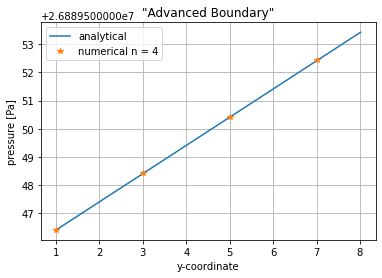

Error at point  2  is  0.0


In [8]:
steady4 = RadialDiffusivityEquationSolver(4,0.01)
steady4.steady()
steady4.steady_error()


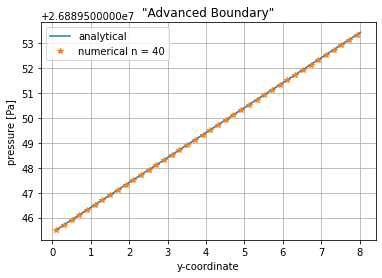

Error at point  20  is  2.2351741790771484e-08


In [9]:
steady40 = RadialDiffusivityEquationSolver(40,0.01)
steady40.steady()
steady40.steady_error()


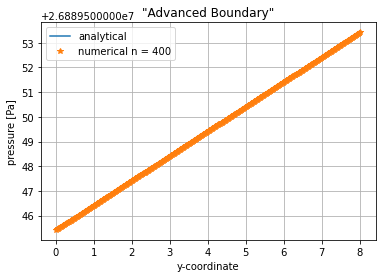

Error at point  200  is  3.203749656677246e-07


In [10]:
steady400 = RadialDiffusivityEquationSolver(400,0.01)
steady400.steady()
steady400.steady_error()


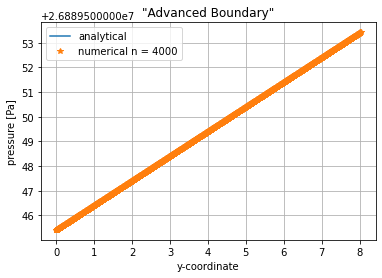

Error at point  2000  is  2.555549144744873e-06


In [11]:
steady4000 = RadialDiffusivityEquationSolver(4000,0.01)
steady4000.steady()
steady4000.steady_error()


Does the numerical error scale as you expect in the two cases? Where do the errors originate from?

Yes the numerical error scales as we expect in the two cases. 

As mentioned in the project description, the second derivative of pressure is zero. Since the truncation error is based on the fourth derivative of pressure, the truncation error is also zero. 

In case of the "Lazy Boundary" the boundry condition for $y=y_e$ introduces some error based on the first derivative of pressure at the point N. This error is based on the step size $\Delta y$. Therefore the error decreases proportional to an increase of N ($\Delta y$ becomes smaller).

In case of the "Advanced Boundary" no such error is introduced and the total error therefore is basically 0 and independent from $\Delta y$ and therefore N. 

## Exercise 2: Time-dependent solution ##


### Part 1: Matrix definition ###

In the time-dependent solution we need to approximate the second derivative based on space and time. By multiplying both sides of equation (29) from the project description with $\Delta t$ we get: 
<br><p style="text-align: center;">$(p^{n+1}_{i+1} + p^{n+1}_{i-1} - 2p^{n+1}_{i})\dfrac{\eta e^{-2y_i} \Delta t}{\Delta y^2 r^2_w} = p^{n+1}_{i} + p^{n}_{i}$(8)</p>
<br> As mentioned in the project description, $\dfrac{\eta e^{-2y_i} \Delta t}{\Delta y^2 r^2_w}$ is equal to $\xi_i$. Therefore (8) becomes:
<br><p style="text-align: center;">$(p^{n+1}_{i+1} + p^{n+1}_{i-1} - 2p^{n+1}_{i})\xi_i= p^{n+1}_{i} + p^{n}_{i}$ 
<br><p style="text-align: center;">$=>(p^{n+1}_{1} + p^{n+1}_{-1} - 2p^{n+1}_{0})\xi_i  - p^{n+1}_{0} = -p^{n}_{0}$ (9)</p>
<br> For the four first ones, (9) is written like:
<br><p style="text-align: center;">$(p^{n+1}_{1} + p^{n+1}_{-1} - 2p^{n+1}_{0})\xi_0  - p^{n+1}_{0} = -p^{n}_{0}$
<br><p style="text-align: center;">$(p^{n+1}_{2} + p^{n+1}_{0} - 2p^{n+1}_{1})\xi_1  - p^{n+1}_{1} = -p^{n}_{1}$
<br><p style="text-align: center;">$(p^{n+1}_{3} + p^{n+1}_{1} - 2p^{n+1}_{2})\xi_2  - p^{n+1}_{2} = -p^{n}_{2}$
<br><p style="text-align: center;">$(p^{n+1}_{4} + p^{n+1}_{2} - 2p^{n+1}_{3})\xi_3  - p^{n+1}_{3} = -p^{n}_{3}$</p>
<br> Using the central difference and imposing the boundary conditions to find a value for 
$p_{-1}$ and $p_4$, we get:
<br><p style="text-align: center;">$\dfrac {p^{n+1}_{0} - p^{n+1}_{-1}} {\Delta y} = \dfrac {Q \mu}{2 \pi k h}$</p>
<br> By substituting $\dfrac {Q \mu}{2 \Delta y \pi k h}$ as $\beta$ we get:
<br><p style="text-align: center;">$p^{n+1}_{-1} = p^{n+1}_{0} - \beta$</p>
<br>The value of $p_4$ considering the boundary condition is:
<br><p style="text-align: center;">$p^{n+1}_{4} = 2 p^{n+1}_e -p^{n+1}_{3}$</p>
<br>Therefore by changing the values and multiplying the previous equations with $\xi$, the new equations are:
<br><p style="text-align: center;">$p^{n+1}_{0}(\xi_0 +1) - p^{n+1}_{1}(- \xi_0) = - \beta \xi_0 + p^{n}_{0}$
<br><p style="text-align: center;">$p^{n+1}_{0}(- \xi_1) - p^{n+1}_{1}(1+2 \xi_1) - p^{n+1}_{2}(- \xi_1) = p^{n}_{1}$
<br><p style="text-align: center;">$p^{n+1}_{1}(- \xi_2) - p^{n+1}_{2}(1+2 \xi_2) - p^{n+1}_{3}(- \xi_2) = p^{n}_{2}$
<br><p style="text-align: center;">$p^{n+1}_{2}(- \xi_3) - p^{n+1}_{3}(1+3 \xi_2)  =  2 p_e \xi_3 + p^{n}_{3}$</p>
<br> Finally the matrix equation is:
<br>$$\begin{pmatrix} 1+\xi_0&-\xi_0&0&0 \\ -\xi_1&1+2\xi_1&-\xi_1&0\\0&-\xi_2&1+2\xi_2&-\xi_2\\ 0&0&-\xi_3&1+3\xi_3 \end{pmatrix}\begin{pmatrix} p^{n+1}_0 \\ p^{n+1}_1\\p^{n+1}_2\\p^{n+1}_3 \end{pmatrix} =\begin{pmatrix} p^{n}_0 \\ p^{n}_1\\p^{n}_2\\p^{n}_3 \end{pmatrix}\begin{pmatrix} -\beta \xi_0 \\ 0\\0\\-2p_e \xi_3\end{pmatrix} $$ 

### Part 2: Matrix calculation ###


The matrix for N=4 in SI units is like the output below:

In [12]:
matrix4 = RadialDiffusivityEquationSolver(N=4,dt=0.01)
print(matrix4.A_)


[[ 6.30844146e+03 -6.30744146e+03  0.00000000e+00  0.00000000e+00]
 [-1.14232623e+02  2.29465247e+02 -1.14232623e+02  0.00000000e+00]
 [ 0.00000000e+00 -2.06884080e+00  5.13768160e+00 -2.06884080e+00]
 [ 0.00000000e+00  0.00000000e+00 -3.74683004e-02  1.11240490e+00]]


### Part 3: Implemented simulator ###

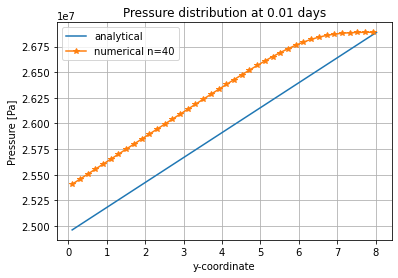

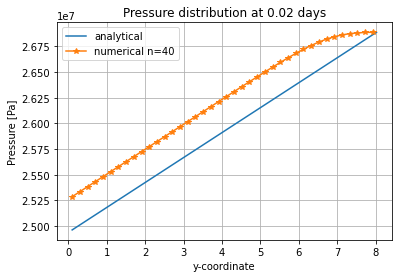

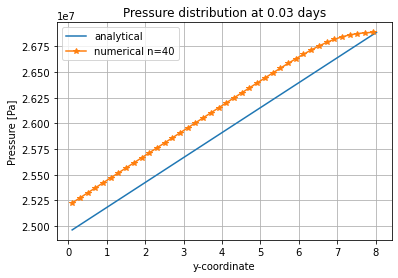

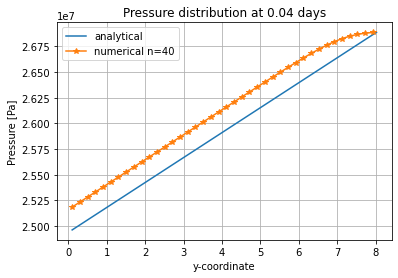

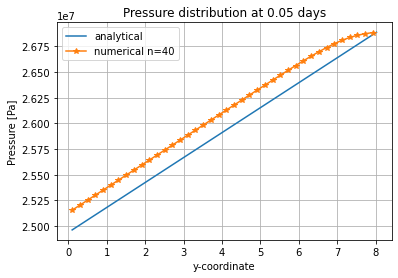

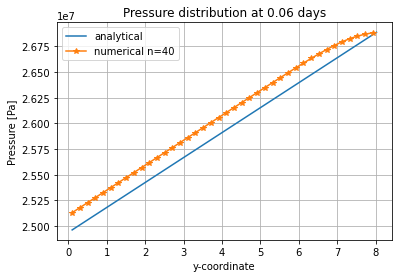

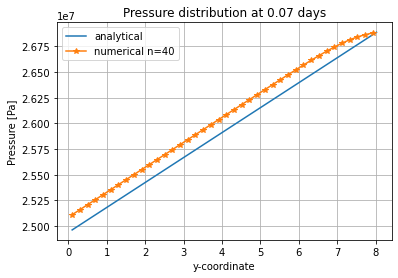

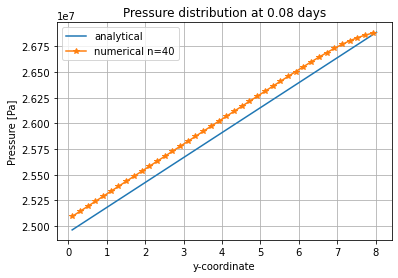

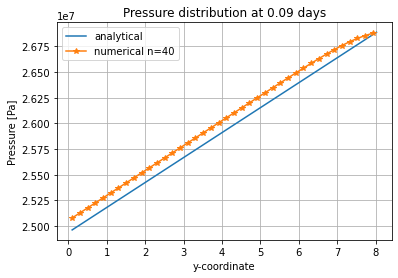

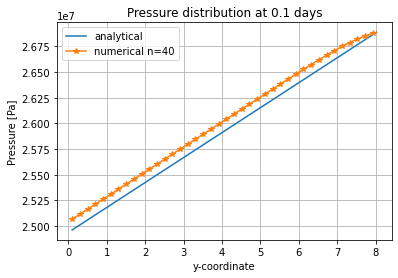

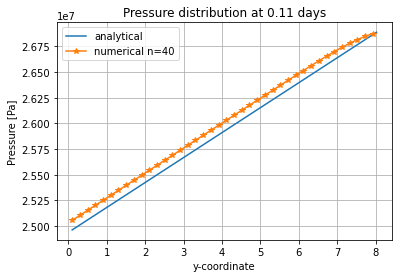

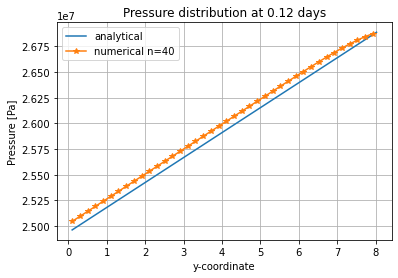

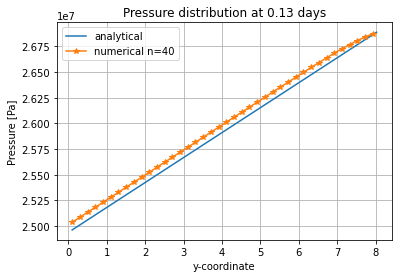

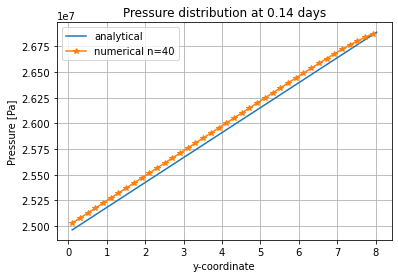

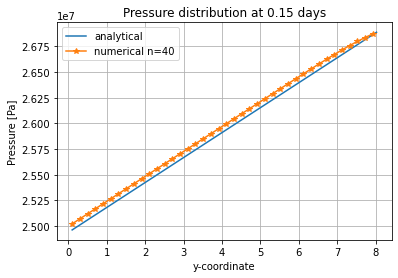

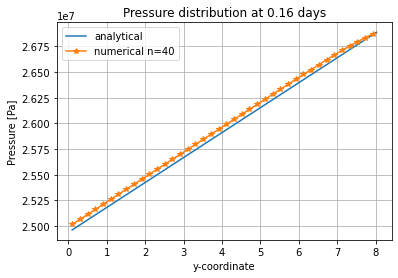

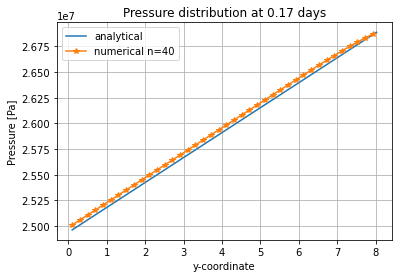

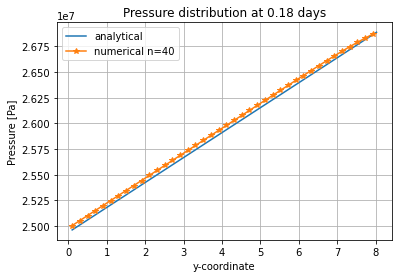

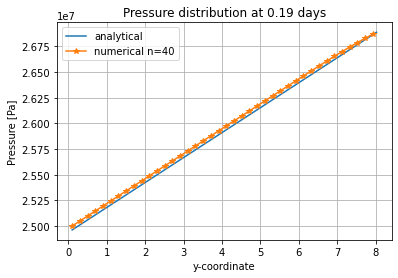

In [13]:
timedependent_dense = RadialDiffusivityEquationSolver(N=40,dt=0.01)

#Run the simulator in timedependent mode using dense matrix solver:
timedependent_dense.timedependent(0.2,plot=True)

Looking at these plots we can observe that by increasing the time step we get more close to the exact solution. In this example we calculate the pressure for N equals to 40 and 0.2 days. 

## Exercise 3: Accuracy and performance ##

### Part 1: Comparison with linesource ###

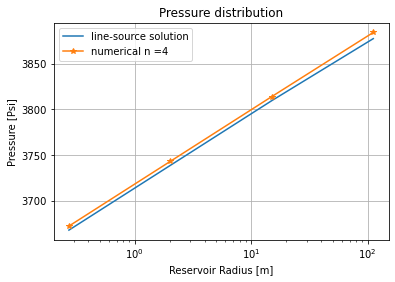

In [14]:
linesource4 = RadialDiffusivityEquationSolver(4,0.01)
#Calculating the pressure using line-source solution
linesource4.line_source(0.1)
#Calculating the pressure using dense solver
linesource4.timedependent(0.1)
#Comparing the results
linesource4.plot_num_vs_line()

There is a disparity between the numerical solution and the outcome of the line-source solution, which can be reduced by raising the value N. As stated in the project description, the line-source solution considers the well to be infinitely small, similar to a line. This signifies that this solution ignores the well's boundaries. As a result, the answer would be inaccurate in close distances to well. We know that $\Delta y$ is bigger when N is equal to 4 than when N is equal to 40, 400, or 4000. In comparison to the numerical solution, which is influenced by the well border, the line-source solution therefore becomes more accurate by lowering the $\Delta y$. For instance, in the code snippet below, we can observe that these two solutions are more similar when N is equal to 40. [9]

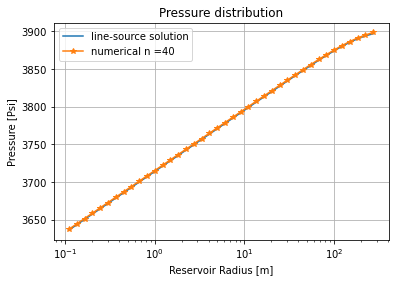

In [15]:
linesource = RadialDiffusivityEquationSolver(40,0.01)
#Calculating the pressure using line-source solution
linesource.line_source(0.1)
#Calculating the pressure using dense solver
linesource.timedependent(0.1)
#Comparing the results
linesource.plot_num_vs_line()

### Part 2: Comparison of dense, SciPy and Thomas algorithm matrix solver ###

169 µs ± 2.89 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
1.93 ms ± 38.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
419 µs ± 8.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


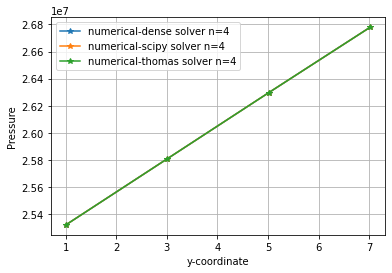

In [16]:
timedependentobj4 = RadialDiffusivityEquationSolver(4,0.01)

%timeit timedependentobj4.timedependent(0.1,matrix_solver='dense')
%timeit timedependentobj4.timedependent(0.1,matrix_solver='SciPy')
%timeit timedependentobj4.timedependent(0.1,matrix_solver='Thomas')
timedependentobj4.plot_comparisonSolvers()

The output of the code snippet above shows that for a small value of N (like N = 4), the fastest solver is the dense matrix solver, the second fastest is the Thomas Algorithm and the slowest is the SciPy matrix solver. If we increase N to 40, we get:

295 µs ± 9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.14 ms ± 53.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.03 ms ± 29.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


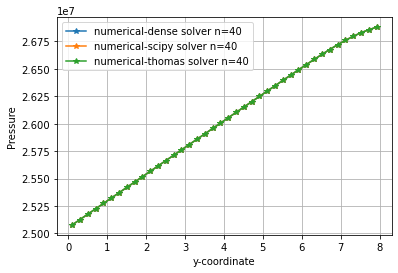

In [17]:
timedependentobj40 = RadialDiffusivityEquationSolver(40,0.01)

%timeit timedependentobj40.timedependent(0.1,matrix_solver='dense')
%timeit timedependentobj40.timedependent(0.1,matrix_solver='SciPy')
%timeit timedependentobj40.timedependent(0.1,matrix_solver='Thomas')
timedependentobj40.plot_comparisonSolvers()

By increasing the value of N to 40 we can observe that the dense matrix solver is still faster than the Thomas Algorithm which is still faster than the SciPy matrix solver.

10.1 ms ± 338 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.13 ms ± 44.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.88 ms ± 155 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


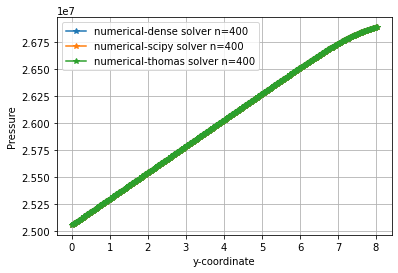

In [18]:
timedependentobj400 = RadialDiffusivityEquationSolver(400,0.01)

%timeit timedependentobj400.timedependent(0.1,matrix_solver='dense')
%timeit timedependentobj400.timedependent(0.1,matrix_solver='SciPy')
%timeit timedependentobj400.timedependent(0.1,matrix_solver='Thomas')
timedependentobj400.plot_comparisonSolvers()

By increasing the value of N to 400 we can observe that the SciPy matrix solver is now faster than the Thomas algorithm which is now faster than the dense matrix solver.

4.55 s ± 316 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
23.3 ms ± 1.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
69 ms ± 1.72 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


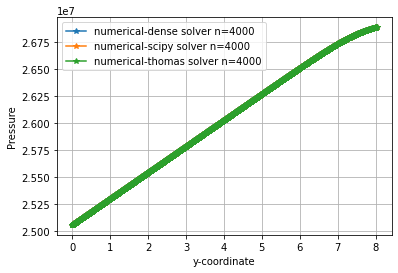

In [19]:
timedependentobj4000 = RadialDiffusivityEquationSolver(4000,0.01)

%timeit timedependentobj4000.timedependent(0.1,matrix_solver='dense')
%timeit timedependentobj4000.timedependent(0.1,matrix_solver='SciPy')
%timeit timedependentobj4000.timedependent(0.1,matrix_solver='Thomas')
timedependentobj4000.plot_comparisonSolvers()

By increasing the value of N to 4000 we can observe that the SciPy matrix solver is still much faster than the Thomas Algorithm which is still much faster than the dense matrix solver.

### Part 3: Numerical error for time-dependent solution ###

When the true solution is not easily analytically calculated (as in the steady state case), we must estimate the error. In this case, the error is the difference between the previous approximated result and the present approximated result.
<br><p style="text-align: center;">error = present approximation - previous approximation</p>
Because the error is proportional to the step size, which in our case is $\Delta y$, we expect the error to decrease as the step size is reduced. We must assume an alternative to the analytical solution to calculate the error. Since it is obvious, that the amount of error decreases as the value of N increases, we can argue that the numerical solution with N equal to 4000 produces results that are more similar to the analytical solution than smaller amounts of N.
Also, as previously stated, line-source solution is more accurate at greater distances from the well, therefore we can use line-source solutions as a base. [10]


Error numerical - numerical: [265757.492560409, 24027.76535248384, 2195.3311760798097, 0.0]
Error numerical - line-source: [274176.89469654113, 32447.16748861596, 10614.73331221193, 8419.402136132121]


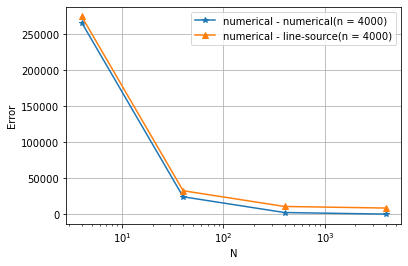

In [27]:

def numeric_error():
    N = [4,40,400,4000]
    error = []
    error_line = []
    point = []
    base = RadialDiffusivityEquationSolver(4000,0.01)
    delta_y = int(base.dy_/2)
    base.timedependent(0.1)
    base.line_source(0.1)
    p_base = base.Pn_[delta_y]
    r_deltay = int(base.rw_*np.exp(delta_y))
    p_base_line = base.Pr_[r_deltay]

    for i in N:
        temp = RadialDiffusivityEquationSolver(N=i,dt=0.01)
        temp.timedependent(0.1)
        d = i
        point.append(d)
  
        p_err = temp.Pn_[delta_y]

        error.append(np.abs(p_err-p_base))
        error_line.append(np.abs(p_err-p_base_line))
        
    
    print('Error numerical - numerical:',error)
    print('Error numerical - line-source:',error_line)
    plt.plot(point,error,'*-',label='numerical - numerical(n = 4000)' )
    plt.plot(point,error_line,'^-', label='numerical - line-source(n = 4000)' )
    plt.xlabel('N')
    plt.ylabel('Error')
    plt.xscale('log')
    plt.legend()
    #plt.yscale('log')
    plt.grid()
        

numeric_error()
        



As shown in the plot, at small values for N the error is significant, because the numerical error is dependent on $\Delta y$, which is a large step size in N = 4. By increasing N and therefore decreasing the step size by a factor of 10, the error gets around 10 times smaller. At large values for N the numerical solution becomes more accurate and gets closer to the analytical (true) solution.

## Exercise 4: Match model to well test data ##

### Part 1: Wellpressure formula ###

The first derivative of pressure over $y$ at $y = y_w$ (at the well) is:
<br><p style="text-align: center;">$\dfrac {dp} {dy} (y = yw) =\dfrac {Q \cdot \mu} {2 \pi \cdot h \cdot k} $ (10)</p>

From Taylors formula we get the numerical 1st derivative (using forward difference):
<br><p style="text-align: center;">$f'(x)=\dfrac{(f(x+h)-f(x))}{h} -\dfrac1 2 h \cdot f''(\eta)$ (11)</p>

In our case:  
<br><p style="text-align: center;">$f'(x) = \dfrac {dp}{dy}$ (12)
<br><p style="text-align: center;">$f(x+h) = p0$ (13)
<br><p style="text-align: center;">$f(x) = pw$ (14)
<br><p style="text-align: center;">$h = \dfrac{\Delta y}{2}$ (15)</p>

with (10), 

p0: The pressure at N = 0 or at y = dy/2,

pw: The pressure at the well or at y = 0

By putting (12-15) into (11) we get the formula for the well pressure:

<br><p style="text-align: center;">$pw = p0 - \dfrac {Q\mu \cdot dy} {4 \pi \cdot h \cdot k}$ (16)</p>


### Part 2: Calculate wellpressure ###

We added the following function to calculate the well pressure using formula (16) to the class:

In [21]:
 def well_pressure(self):
        p0=self.Pn_[0]
        pw = p0-(self.Q_*self.mu_*self.dy_)/(4*np.pi*self.h_*self.k_)
        return pw


### Part 3: Import and plot data ###

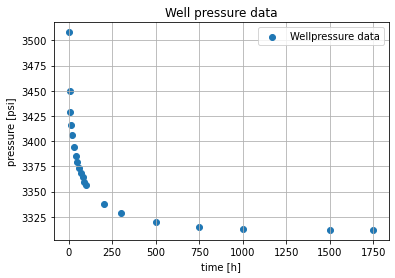

In [22]:
#read data
bhpData = pd.read_csv('./data/well_bhp.dat',sep='\t')
#add units
bhpData.rename(columns={'time':'time [h]','well_pressure':'well_pressure [psi]'}, inplace=True)

#plot data
plt.scatter(bhpData['time [h]'],bhpData['well_pressure [psi]'],label='Wellpressure data')
plt.xlabel('time [h]')
plt.ylabel('pressure [psi]')
plt.title('Well pressure data')
plt.grid()
plt.legend()
plt.show()


### Part 4.1: Manually fit model to data ###

Here we manually try different values for k, pi and re to fit the model to the data using the plot containing both data and model well pressure with linear and/or logarithmic time scale, aswell as sum, mean and standard deviation of the squared residuals ("Least Square Method") and a plot showing the squard residuals over physical time.

To keep the computation times low while manually fitting the model to the data we choose N = 40, which is accurate enough.

Bellow is an excerpt of 10 combinations of k, pi and re values we tried showcasing their evolution in our trial and error method.

Uncomment one of them and comment out the rest to try out and compare the results for different values.

,time [h],well_pressure [psi],time [days],well_pressure_model [psi],Residuals,ResSquared
0,1.0,3508,0.041667,3508.162576,0.162576,0.026431
1,5.0,3450,0.208333,3448.060498,-1.939502,3.761669
2,10.0,3429,0.416667,3426.548686,-2.451314,6.008939
3,15.0,3416,0.625000,3414.356692,-1.643308,2.700461
4,20.0,3406,0.833333,3405.811863,-0.188137,0.035395
5,30.0,3394,1.250000,3393.870279,-0.129721,0.016828
6,40.0,3385,1.666667,3385.449158,0.449158,0.201743
7,50.0,3379,2.083333,3378.938715,-0.061285,0.003756
8,60.0,3373,2.500000,3373.630311,0.630311,0.397292
9,70.0,3368,2.916667,3369.148569,1.148569,1.319211


Sum of squared Residuals: 29.089983353189197
Mean of squared Residuals: 1.4544991676594599
Standard deviation of squared Residuals: 1.7129880427909576


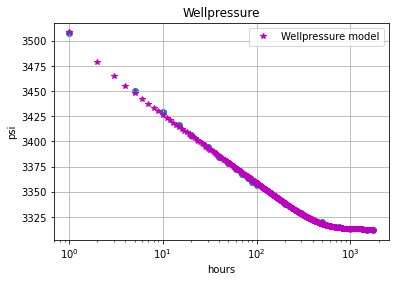

In [23]:

# well_bhp_model=RadialDiffusivityEquationSolver(N=40,dt=1/24,k=300,pi=3900,re=7000) #Sum sqRes: 65.49851314722396, mean: 3.274925657361198, sd: 3.28640395658201
# well_bhp_model=RadialDiffusivityEquationSolver(N=40,dt=1/24,k=310,pi=3887,re=8000) #Sum sqRes: 54.84004273557715, mean: 2.7420021367788574, sd: 3.038418007726227
# well_bhp_model=RadialDiffusivityEquationSolver(N=40,dt=1/24,k=308.5,pi=3889,re=8000) #Sum sqRes: 49.38261793558112, mean: 2.469130896779056, sd: 2.207173594345721
# well_bhp_model=RadialDiffusivityEquationSolver(N=40,dt=1/24,k=307,pi=3890,re=7500) #Sum sqRes: 38.986066219930755, mean: 1.9493033109965379, sd: 2.94582789289213
# well_bhp_model=RadialDiffusivityEquationSolver(N=40,dt=1/24,k=306.66,pi=3891,re=7500) #Sum sqRes: 32.636135549346434, mean: 1.6318067774673217, sd: 2.0211105103439433
# well_bhp_model=RadialDiffusivityEquationSolver(N=40,dt=1/24,k=306.6,pi=3891.5,re=7700) #Sum sqRes: 32.14808756848702, mean: 1.607404378424351, sd: 1.7763399777081357
# well_bhp_model=RadialDiffusivityEquationSolver(N=40,dt=1/24,k=306.6,pi=3891.6,re=7750) #Sum sqRes: 34.00497248665282, mean: 1.700248624332641, sd: 1.7815957804723772
# well_bhp_model=RadialDiffusivityEquationSolver(N=40,dt=1/24,k=306,pi=3892.3,re=7600) #Sum sqRes: 29.33611739613059, mean: 1.4668058698065294, sd: 1.6861411937344133
# well_bhp_model=RadialDiffusivityEquationSolver(N=40,dt=1/24,k=306,pi=3892.3,re=7591) #Sum sqRes: 29.28206758151267, mean: 1.4641033790756335, sd: 1.6762717521391794
well_bhp_model=RadialDiffusivityEquationSolver(N=40,dt=1/24,k=305.9,pi=3892.4,re=7591) #Sum sqRes: 29.089983353189197, mean: 1.4544991676594599, sd: 1.7129880427909576

#add column with timedata in days to the dataframe
bhpData['time [days]']=bhpData['time [h]']/24
t_final_days = bhpData['time [h]'].iloc[-1]/24 #last time datapoint in days

#solve the model using dense matrix solver, which is fastest for N = 40 (see Exercise 3 Part 2)
well_bhp_model.timedependent(t_final_days, matrix_solver='dense')

#plot model and data in one plot (uncomment one of following 2 lines to choose linear or logarithmic scale)

# well_bhp_model.plot_well_pressure(timescale='hours',pressure_unit='psi',xscale='linear')
well_bhp_model.plot_well_pressure(timescale='hours',pressure_unit='psi',xscale='log')

plt.scatter(bhpData['time [h]'],bhpData['well_pressure [psi]'],label='Wellpressure data')

#Get model results for pw at data timedata points. pw_interp_fun returns pw in psi.
well_bhp_model.pw_interp_fun(t_data_hours=bhpData['time [h]'])

#add model results to dataframe
bhpData['well_pressure_model [psi]']=well_bhp_model.pw_interp_psi_

#Calculate Residuals using model results for pw and add to dataframe
bhpData['Residuals']=bhpData['well_pressure_model [psi]']-bhpData['well_pressure [psi]']

#Calculate square of Residuals ("Least Square Method") and add to dataframe
bhpData['ResSquared']=bhpData['Residuals']*bhpData['Residuals']

#display Dataframe and print squared Residual statistics
display(bhpData)
print('Sum of squared Residuals:',bhpData['ResSquared'].sum())
print('Mean of squared Residuals:',bhpData['ResSquared'].mean())
print('Standard deviation of squared Residuals:',bhpData['ResSquared'].std())

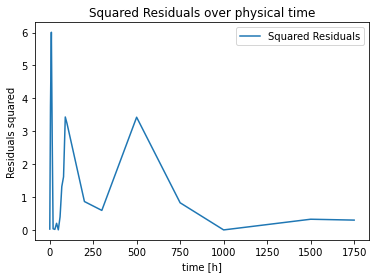

In [24]:
#plot squared residuals over physical time
plt.plot(bhpData['time [h]'],bhpData['ResSquared'], label = 'Squared Residuals')
plt.xlabel('time [h]')
plt.ylabel('Residuals squared')
plt.title('Squared Residuals over physical time')
plt.legend()
plt.show()

### Part 4.2: Automated curve fitting (not working) ###

We tried to use scipy.optimize.curve_fit to automate the matching of the model to the data, but this resulted in a TypeError that could not be resolved in time. (Uncomment the whole cell below to try)

In [25]:
# def optimisation(t_days,gamma):
#     """ 
#     returns well pressure in psi
#     """
#     t_final_days = np.max(t_days)
#     optimiser = RadialDiffusivityEquationSolver(N=400,dt=1/24,k=gamma[0],re=gamma[1],pi=gamma[2])
#     optimiser.timedependent(t_final_days)
#     optimiser.pw_interp_fun(t_days*24)
#     return optimiser.pw_interp_psi_

# t_days = bhpData['time [days]'].to_numpy()
# gamma = [360,7000,3800]
# xdata = bhpData['time [days]'].to_numpy()
# ydata = bhpData['well_pressure [psi]'].to_numpy()

# print (t_days)
# sciopt.curve_fit(optimisation(t_days,gamma),xdata,ydata)

### Part 5: Volume of water ###

We calculate the volume of water in the reservoir assuming the reservoir to be of a cylindrical shape with height h, radius re and porosity phi, the pores to be completely filled with water and neglecting the well volume

In [26]:
Volume_Water = well_bhp_model.calculate_volume()
print('The Water Volume is ',np.round(Volume_Water,2),'cubic meters.')

The Water Volume is  8201867.07 cubic meters.


## Conclusion ##


- Putting effort into defining precise boundary conditions can reduce error sources significantly 
- A models performance should be validated against a known solution
- Different matrix solvers can be more efficient depending on the grid size
- Manually matching a model to messured data can be a time consuming process
- A well matched model can deliver insight in physically hard to directly measure characteristics of a real world problem

## Selfreflection ##



 - Learned more about
    - working with classes and functions 
    - using LaTeX to showcase mathematical contexts in jupyter notebooks
    - using jupyter notebooks and markdown structures to write a scientific project report for numerical simulations
    - using analytical solutions and Data(pandas) to validate a model and fit it´s parameters to the data
    - visualisation using matplotlib
    - different methods to solve steady-state and time-dependent problems
    - evaluating a model´s performance using residuals ("Least Square Method")
    - learning more about boundry conditions, truncation error, and taylors formula
    - undrestanding the difference between analytical anad numerical solution by visualisation
    - learning how to solve matrix equations
    - working with matplotlib and scipy
    - working with three different solver
    - learning how to use the mathematical equations in a natural phenomenon
    - evaluating error of the different solvers
    - working with a class instead of duplicated functions

 - Faced difficulties while
    - implementing the automated curve fitting using SciPy
    - getting started creating a model from scratch when the physical background is unfamiliar
    - implementing the SciPy solver and importing related packages
    - analyzing some plots 
    - understanding the thomas algorithm

## References ##

- [1] Mohamed Abdelaal and Mehdi Zeidouni. Injection data analysis using material balance time for CO2 storage capacity estimation in deep closed saline aquifers. Journal of Petroleum Science and Engineering 208 (2022) 109385.
- [2] L.P. Dake. Fundamentals of Reservoir Engineering. Elsevier, 1983.
- [3] Abdus Satter and Ghulam M. Iqbal. Fundamentals of fluid flow through porous media, Reservoir Engineering (Pages 155-169), 2016.
- [4] Roland F. Krueger. An overview of formation damage and well productivity in oilfield operations: an update. In SPE California Regional Meeting. Society of Petroleum Engineers, 1988.
- [5] John Lee, John B. Rollins, and John Paul Spivey. Pressure Transient Testing. Richardson, Tex.: Henry L. Doherty Memorial Fund of AIME, Society of Petroleum Engineers, 2003.
- [6] Aksel Hiorth. Computational Engineering and Modeling. https://github.com/ahiorth/CompEngineering, 2021.
- [7] Emeka Emmanuel Okoro, Austin Okoh, Evelyn Bose Ekeinde and Adewale Dosunmu. Reserve Estimation Using Decline Curve Analysis for Boundary-Dominated Flow Dry Gas Wells. Arabian Journal for Science and Engineering, 2019.
- [8] Shan Xie, Yifei Lan, Yang Jiao, et al. Research of Dynamic Reserves Estimation Methods for
Complex Gas Wells in Low Permeability and Tight Gas Reservoir. IOP Conf. Series: Earth and Environmental Science 237 (2019) 042002.
- [9] Per Arne Slotte and Carl Fredrik Berg. Lecture notes in well-testing. Department of Geoscience and Petroleum NTNU.
 https://folk.ntnu.no/perarnsl/Literatur/lecture_notes.pdf, 2021.
- [10] Introduction to Numerical Methods/Measuring Errors. https://en.wikibooks.org/wiki/Introduction_to_Numerical_Methods/Measuring_Errors, 2018.
